### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [2]:
ls /mnt/team/simulation_science/pub/models/vivarium_nih_us_cvd/results/vv_medication_discontinuation/alabama/2023_11_17_16_30_13/count_data

binned_ldl_exposure_time.csv     risk_exposure_time.csv
binned_ldl_exposure_time.hdf     risk_exposure_time.hdf
binned_sbp_exposure_time.csv     sbp_medication_person_time.csv
binned_sbp_exposure_time.hdf     sbp_medication_person_time.hdf
deaths.csv                       state_person_time.csv
deaths.hdf                       state_person_time.hdf
healthcare_visits.csv            transition_count.csv
healthcare_visits.hdf            transition_count.hdf
intervention_person_time.csv     ylds.csv
intervention_person_time.hdf     ylds.hdf
ldlc_medication_person_time.csv  ylls.csv
ldlc_medication_person_time.hdf  ylls.hdf


In [3]:
sim_results_dir = '/mnt/team/simulation_science/pub/models/vivarium_nih_us_cvd/results/vv_medication_discontinuation/alabama/2023_11_17_16_30_13/count_data'

## Checking Stability of Risks over Time

In [4]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year','input_draw','scenario']).ptvalue.sum().reset_index()
per_time_group.head()

,age,sex,year,input_draw,scenario,ptvalue
0,25_to_29,Female,2021,29,baseline,29559.260780
1,25_to_29,Female,2021,29,lifestyle_100,29559.260780
2,25_to_29,Female,2021,29,outreach_100,29559.260780
3,25_to_29,Female,2021,29,polypill_100,29559.260780
4,25_to_29,Female,2021,232,baseline,29332.424367


# SBP Medications

In [5]:
meds = pd.read_csv(sim_results_dir + '/sbp_medication_person_time.csv')
meds.head()

,Unnamed: 0,sex,year,measure,input_draw,scenario,age,medication_adherence,sbp_medication,value
0,0,Female,2021,sbp_medication_person_time,29,baseline,25_to_29,primary_non_adherent,no_treatment,4335.496235
1,1,Female,2021,sbp_medication_person_time,29,lifestyle_100,25_to_29,primary_non_adherent,no_treatment,4335.496235
2,2,Female,2021,sbp_medication_person_time,29,outreach_100,25_to_29,primary_non_adherent,no_treatment,4335.496235
3,3,Female,2021,sbp_medication_person_time,29,polypill_100,25_to_29,primary_non_adherent,no_treatment,4335.496235
4,4,Female,2021,sbp_medication_person_time,29,baseline,25_to_29,secondary_non_adherent,no_treatment,2757.453799


In [8]:
meds_adherent = meds.groupby(['sex', 'year', 'input_draw', 'age', 'sbp_medication','scenario']).value.sum().reset_index()
meds_adherent_rate = meds_adherent.merge(per_time_group[['ptvalue','sex','age','year','input_draw','scenario']], on=['sex','age','year','input_draw','scenario'])
meds_adherent_rate['meds_adherent_rate'] = meds_adherent_rate['value'] / meds_adherent_rate['ptvalue']
meds_adherent_rate_summ = (meds_adherent_rate
                .groupby(['sex', 'year', 'sbp_medication','age', 'scenario'])
                .meds_adherent_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
meds_adherent_rate_summ

,sex,year,sbp_medication,age,scenario,mean,2.5%,97.5%
0,Female,2021,no_treatment,25_to_29,baseline,0.913441,0.906285,0.923047
1,Female,2021,no_treatment,25_to_29,lifestyle_100,0.913441,0.906285,0.923047
2,Female,2021,no_treatment,25_to_29,outreach_100,0.913441,0.906285,0.923047
3,Female,2021,no_treatment,25_to_29,polypill_100,0.913441,0.906285,0.923047
...,...,...,...,...,...,...,...,...
16796,Male,2040,two_drug_std_dose_efficacy,95_plus,baseline,0.031633,0.018766,0.042082
16797,Male,2040,two_drug_std_dose_efficacy,95_plus,lifestyle_100,0.031474,0.020460,0.042259
16798,Male,2040,two_drug_std_dose_efficacy,95_plus,outreach_100,0.033191,0.021927,0.041996
16799,Male,2040,two_drug_std_dose_efficacy,95_plus,polypill_100,0.000794,0.000000,0.003457


In [9]:
meds_adherent_rate_summ = meds_adherent_rate_summ.loc[meds_adherent_rate_summ.scenario == 'baseline']

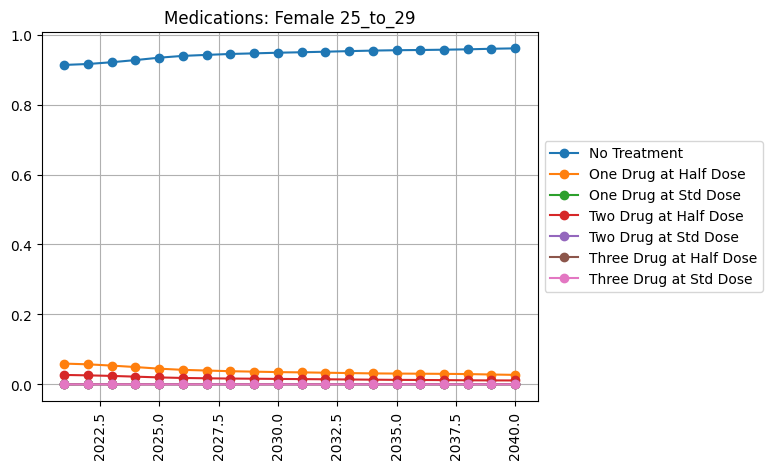

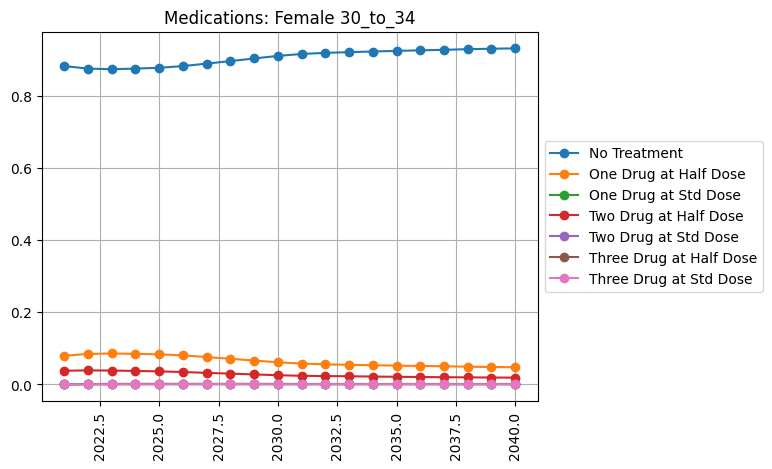

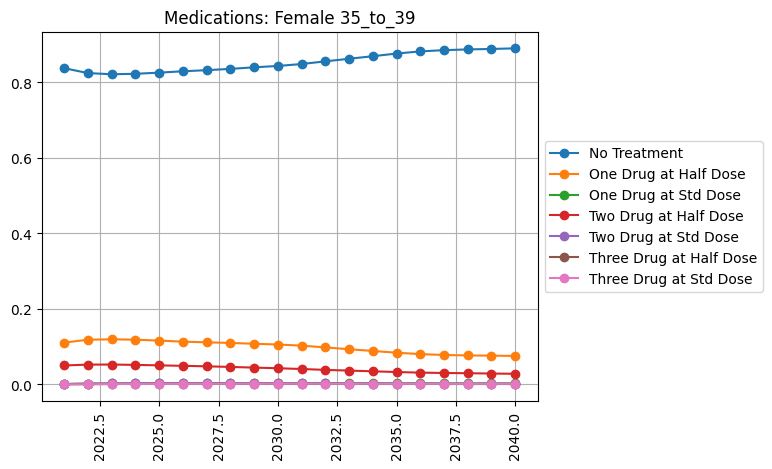

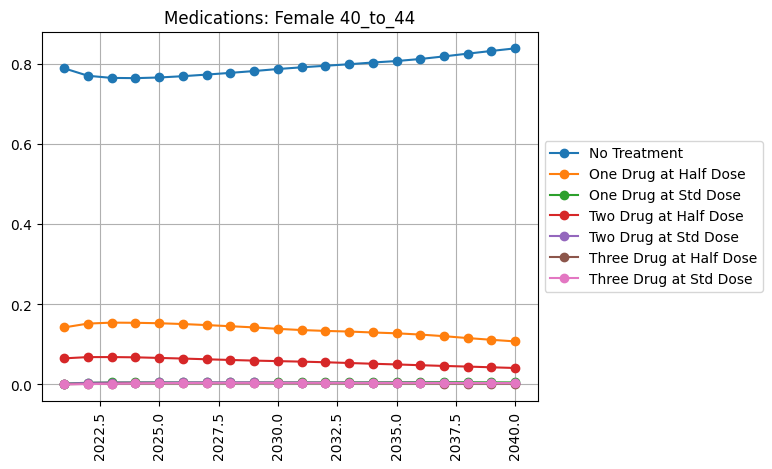

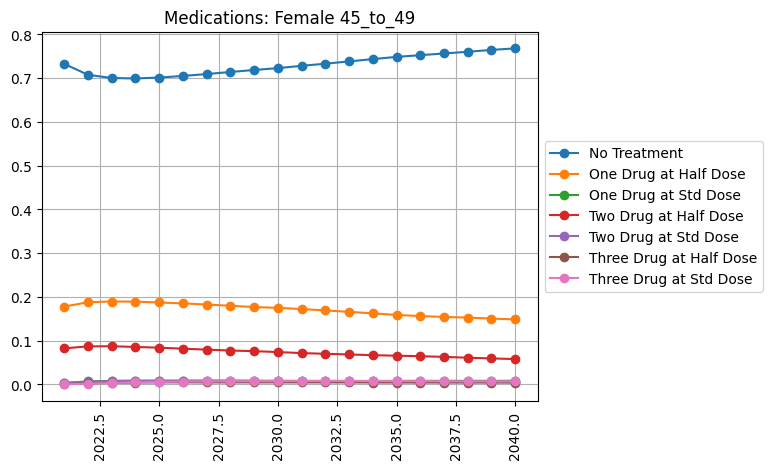

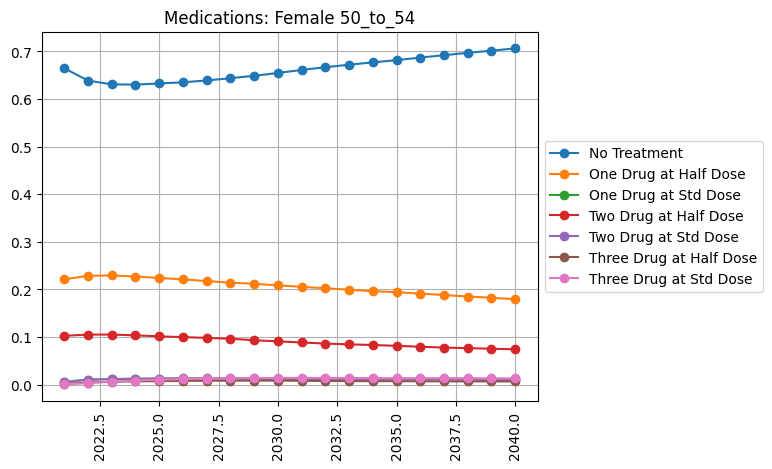

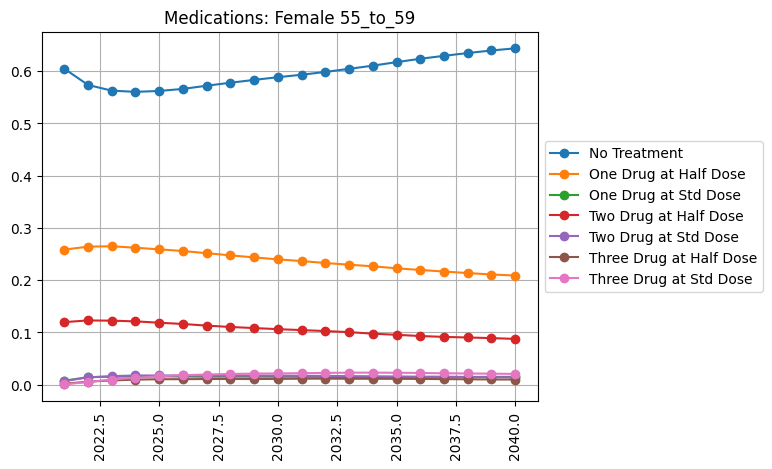

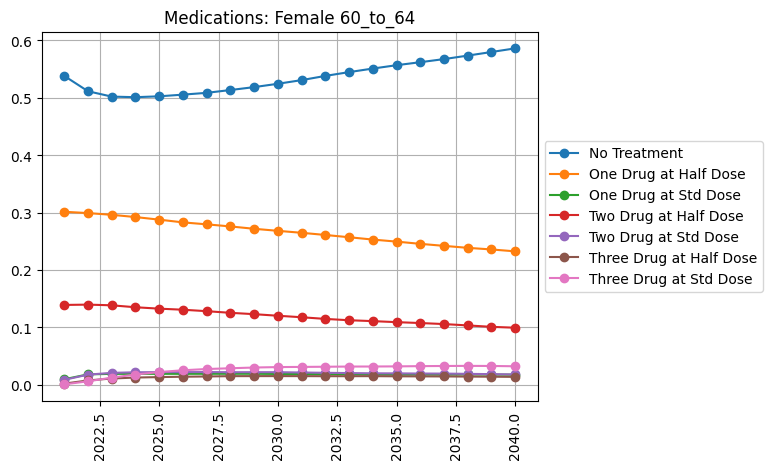

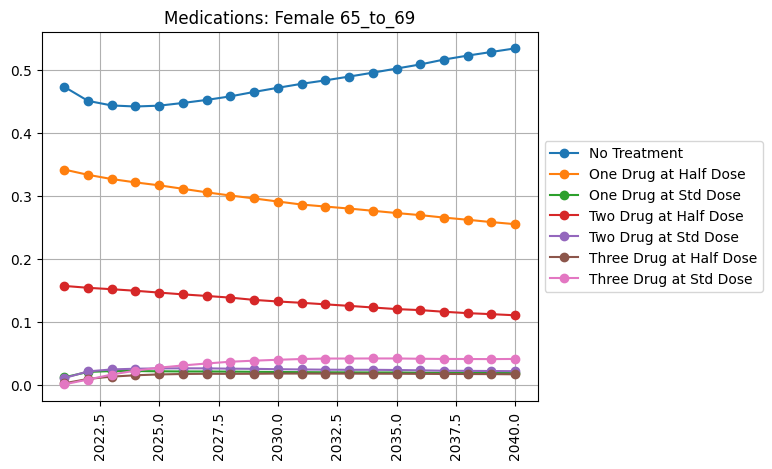

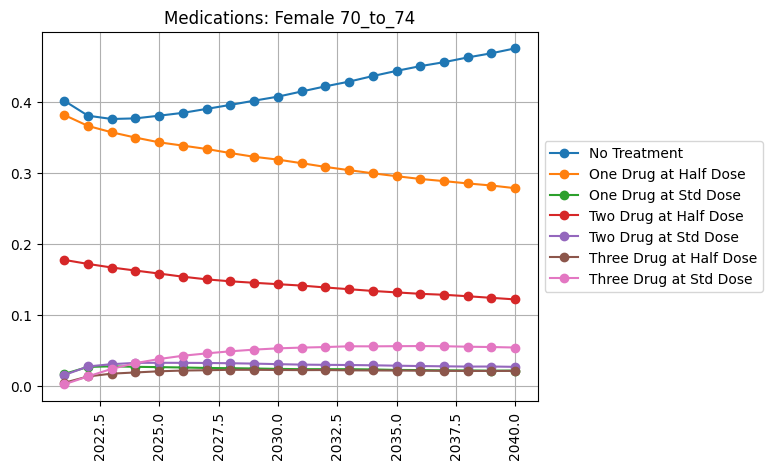

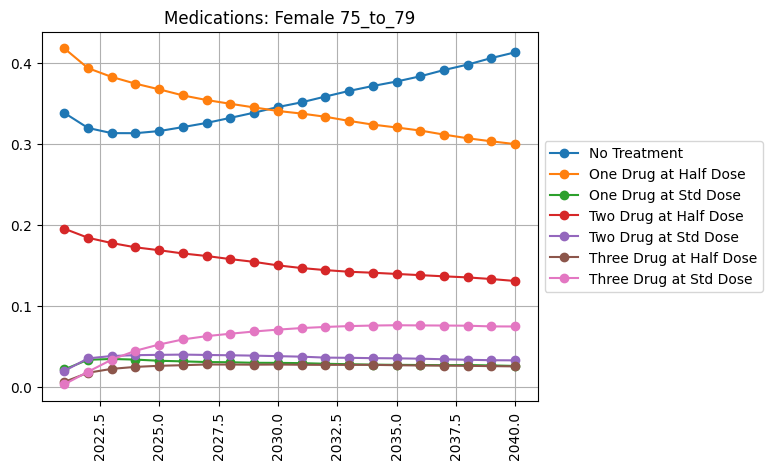

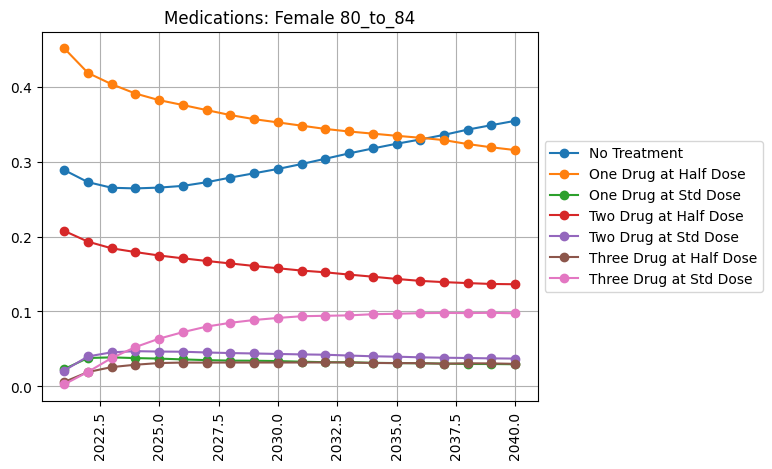

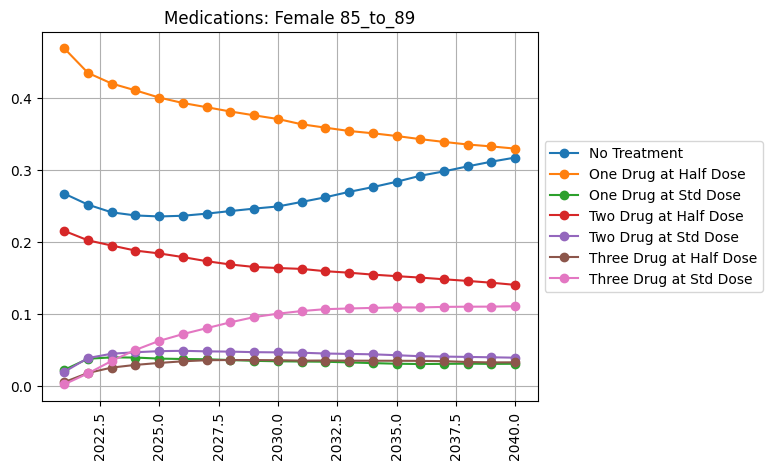

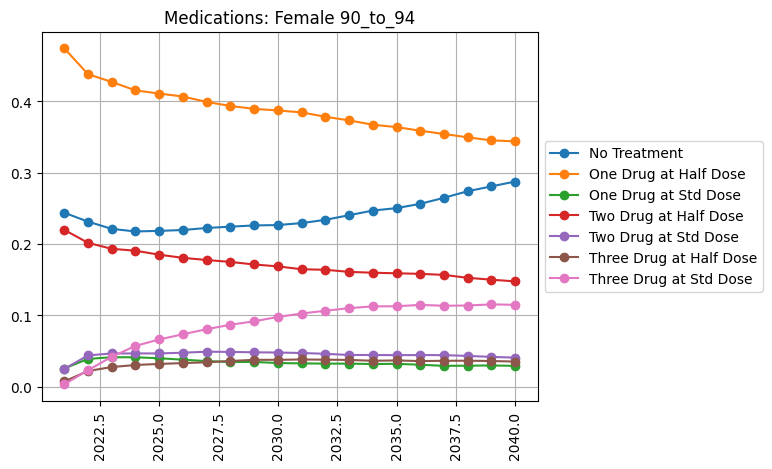

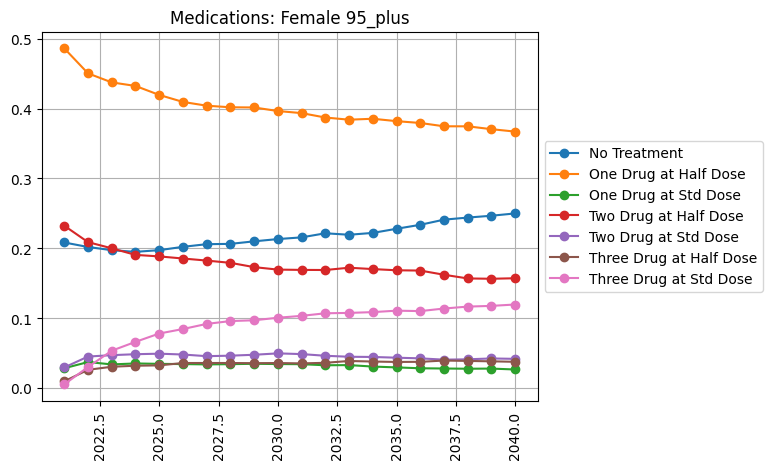

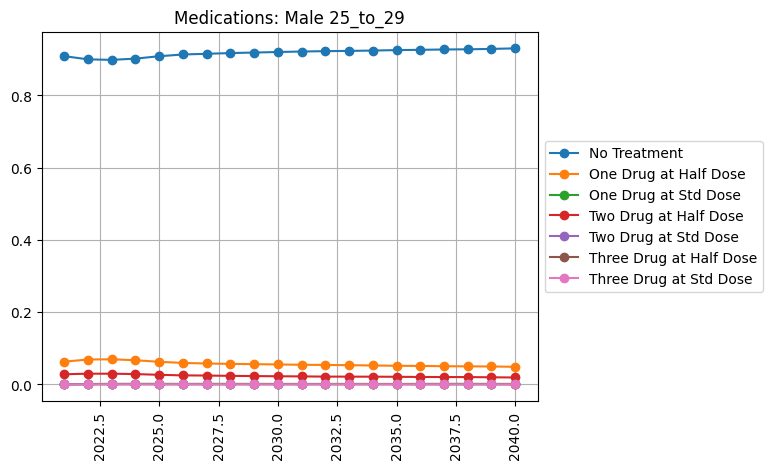

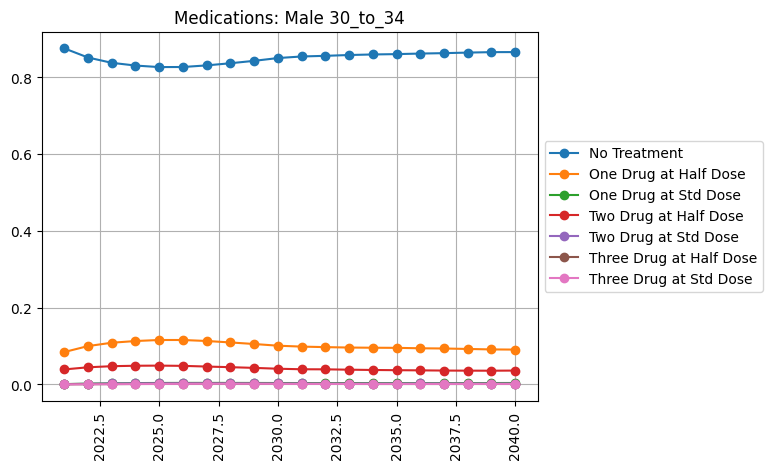

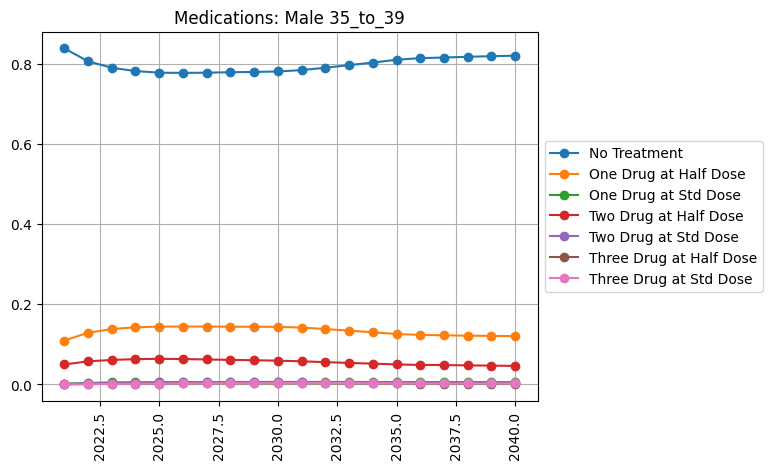

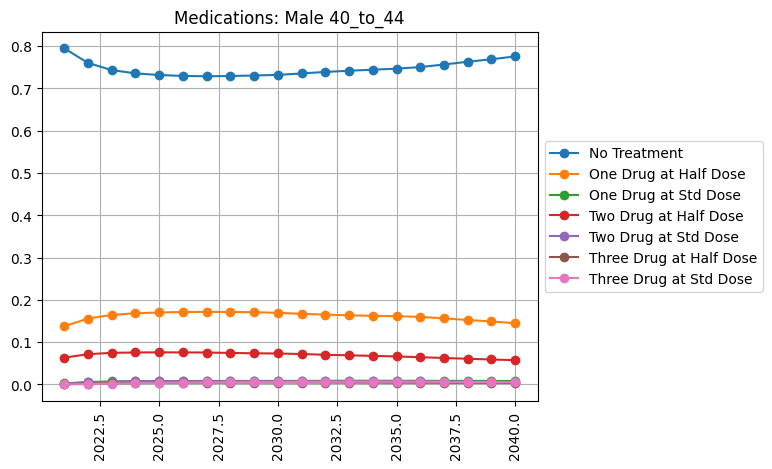

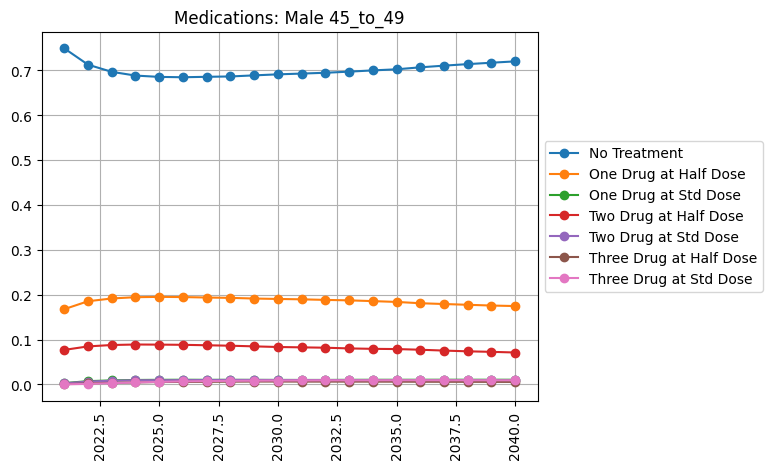

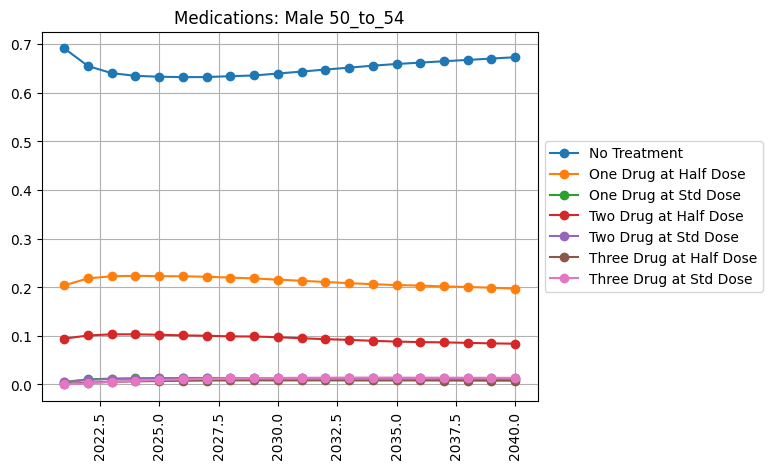

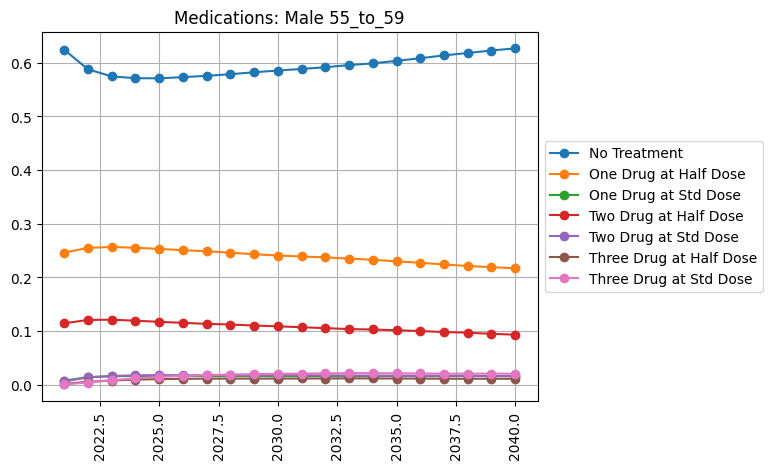

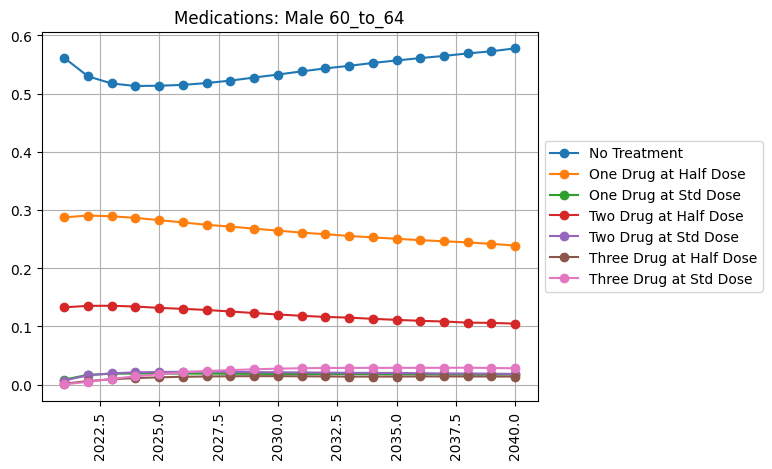

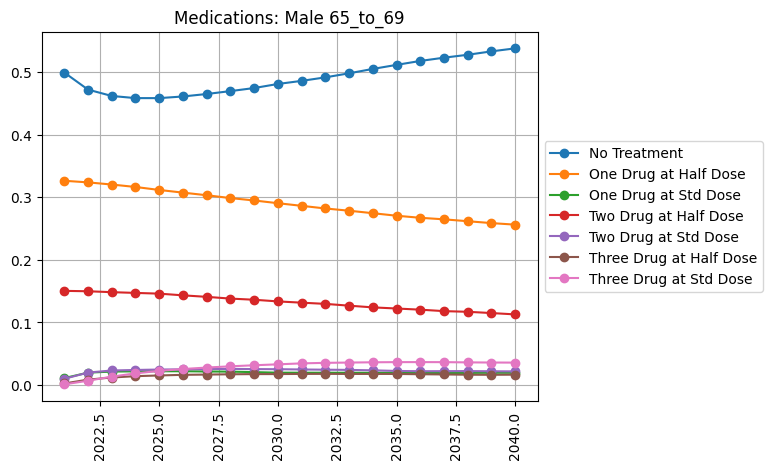

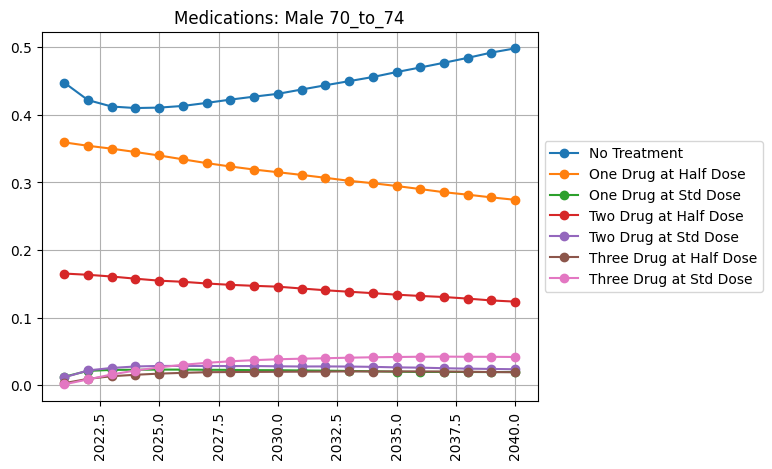

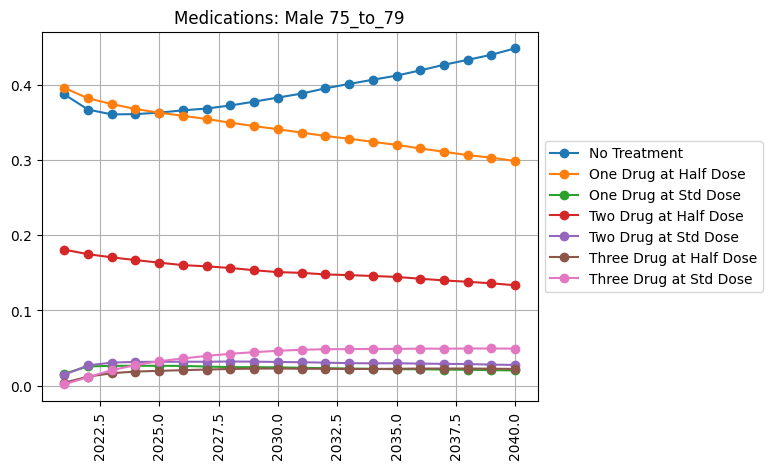

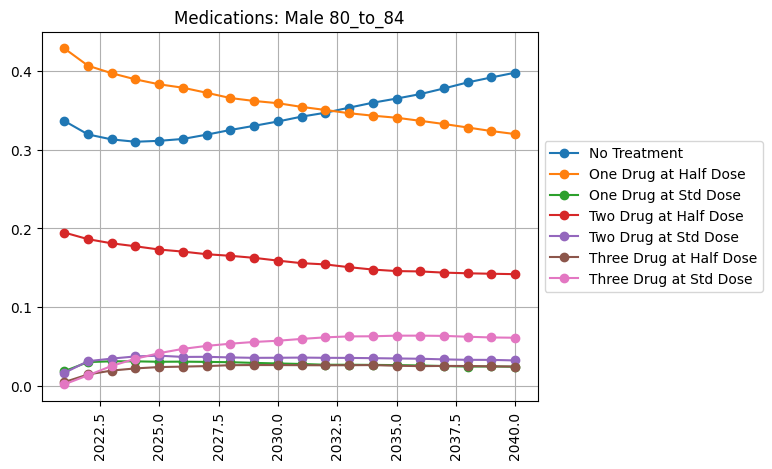

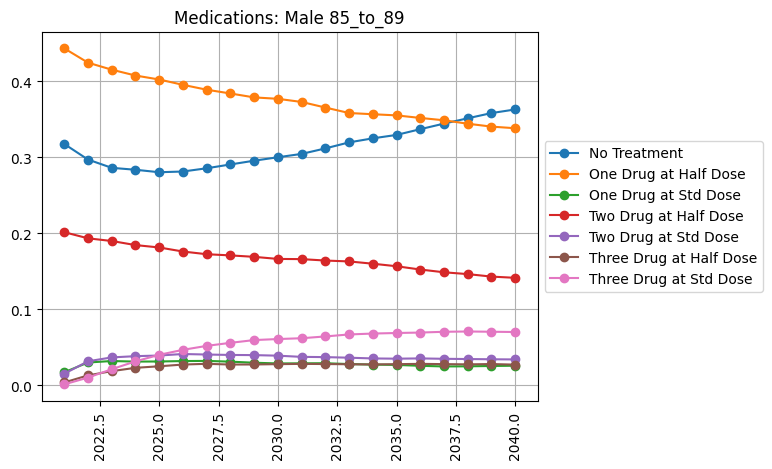

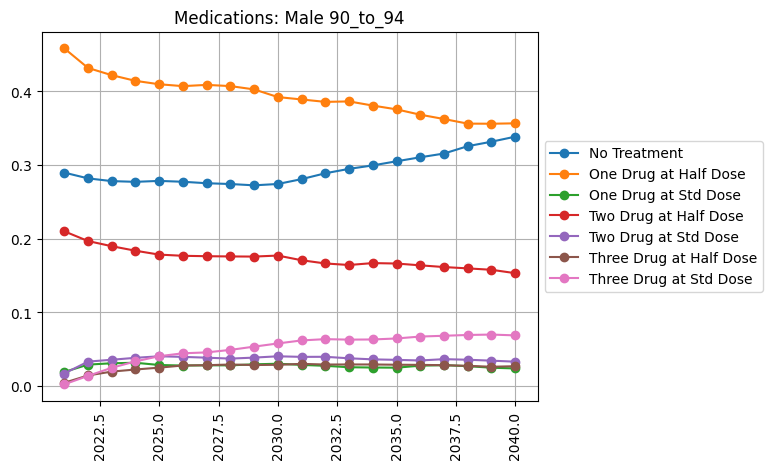

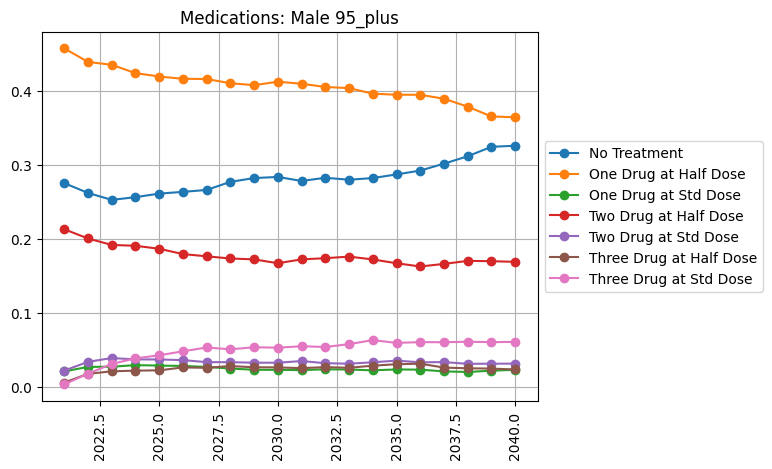

In [10]:
#%%capture
for sex in meds_adherent_rate_summ.sex.unique():
    for age in meds_adherent_rate_summ.age.unique(): 
        plt.figure() 
        no_trt = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='no_treatment')]
        plt.plot(no_trt['year'], no_trt['mean'], marker='o')
        one_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='one_drug_half_dose_efficacy')]
        plt.plot(one_half['year'], one_half['mean'], marker='o')
        one_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='one_drug_std_dose_efficacy')]
        plt.plot(one_std['year'], one_std['mean'], marker='o')
        two_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='two_drug_half_dose_efficacy')]
        plt.plot(two_half['year'], two_half['mean'], marker='o')
        two_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='two_drug_std_dose_efficacy')]
        plt.plot(two_std['year'], two_std['mean'], marker='o')
        three_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='three_drug_half_dose_efficacy')]
        plt.plot(three_half['year'], three_half['mean'], marker='o')
        three_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='three_drug_std_dose_efficacy')]
        plt.plot(three_std['year'], three_std['mean'], marker='o')
        plt.title(f'Medications: {sex} {age}') 
        plt.xticks(rotation=90)
        plt.legend(['No Treatment', 'One Drug at Half Dose','One Drug at Std Dose','Two Drug at Half Dose','Two Drug at Std Dose','Three Drug at Half Dose','Three Drug at Std Dose'],loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid()

In [11]:
ldl_meds = pd.read_csv(sim_results_dir + '/ldlc_medication_person_time.csv')
ldl_meds.head()

,Unnamed: 0,sex,year,measure,input_draw,scenario,age,medication_adherence,ldlc_medication,value
0,0,Female,2021,ldlc_medication_person_time,29,baseline,25_to_29,primary_non_adherent,high_intensity,0.0
1,1,Female,2021,ldlc_medication_person_time,29,lifestyle_100,25_to_29,primary_non_adherent,high_intensity,0.0
2,2,Female,2021,ldlc_medication_person_time,29,outreach_100,25_to_29,primary_non_adherent,high_intensity,0.0
3,3,Female,2021,ldlc_medication_person_time,29,polypill_100,25_to_29,primary_non_adherent,high_intensity,0.0
4,4,Female,2021,ldlc_medication_person_time,29,baseline,25_to_29,secondary_non_adherent,high_intensity,0.0


In [12]:
meds_adherent = ldl_meds #.loc[ldl_meds['medication_adherence']=='adherent'].reset_index()
meds_adherent_rate = meds_adherent.merge(per_time_group[['ptvalue','sex','age','year','input_draw','scenario']], on=['sex','age','year','input_draw','scenario'])
meds_adherent_rate['meds_adherent_rate'] = meds_adherent_rate['value'] / meds_adherent_rate['ptvalue']
meds_adherent_rate_summ = (meds_adherent_rate
                .groupby(['sex', 'year', 'ldlc_medication','age','scenario'])
                .meds_adherent_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
meds_adherent_rate_summ

,sex,year,ldlc_medication,age,scenario,mean,2.5%,97.5%
0,Female,2021,high_intensity,25_to_29,baseline,0.002756,0.000000,0.009133
1,Female,2021,high_intensity,25_to_29,lifestyle_100,0.002756,0.000000,0.009133
2,Female,2021,high_intensity,25_to_29,outreach_100,0.002756,0.000000,0.009133
3,Female,2021,high_intensity,25_to_29,polypill_100,0.002756,0.000000,0.009133
...,...,...,...,...,...,...,...,...
14396,Male,2040,no_treatment,95_plus,baseline,0.161430,0.039210,0.342486
14397,Male,2040,no_treatment,95_plus,lifestyle_100,0.161559,0.040540,0.339902
14398,Male,2040,no_treatment,95_plus,outreach_100,0.161525,0.041223,0.385827
14399,Male,2040,no_treatment,95_plus,polypill_100,0.160791,0.040229,0.347753


In [13]:
meds_adherent_rate_summ = meds_adherent_rate_summ.loc[meds_adherent_rate_summ.scenario == 'baseline']

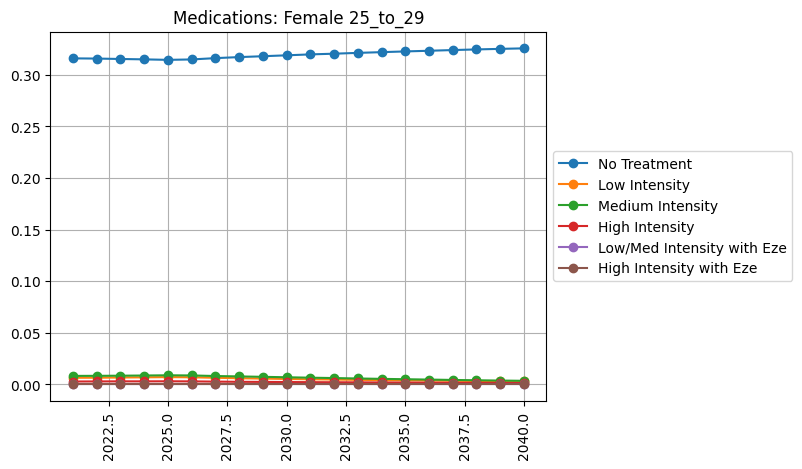

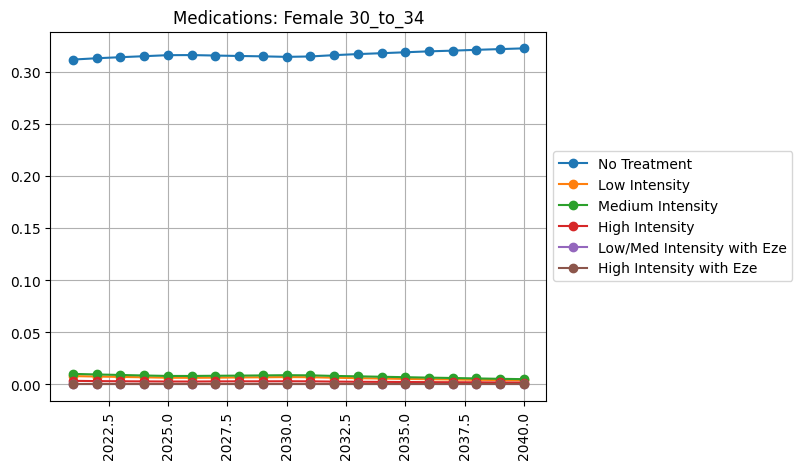

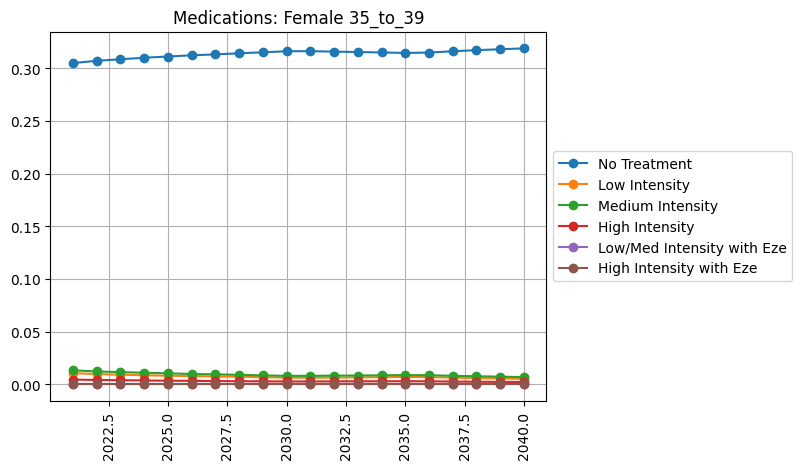

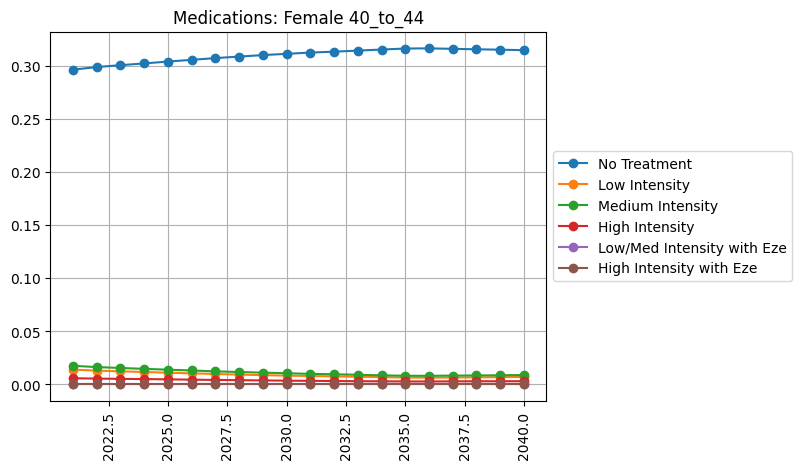

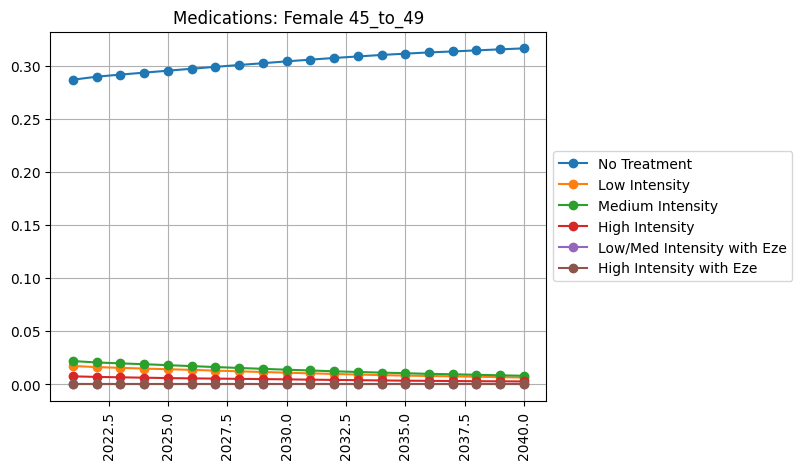

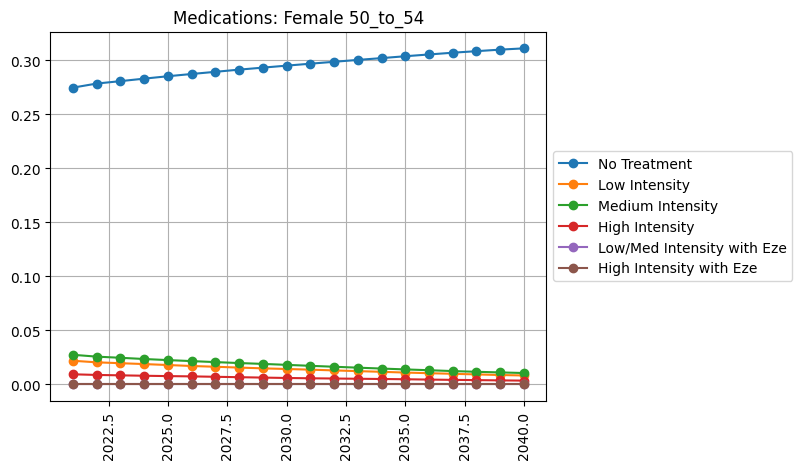

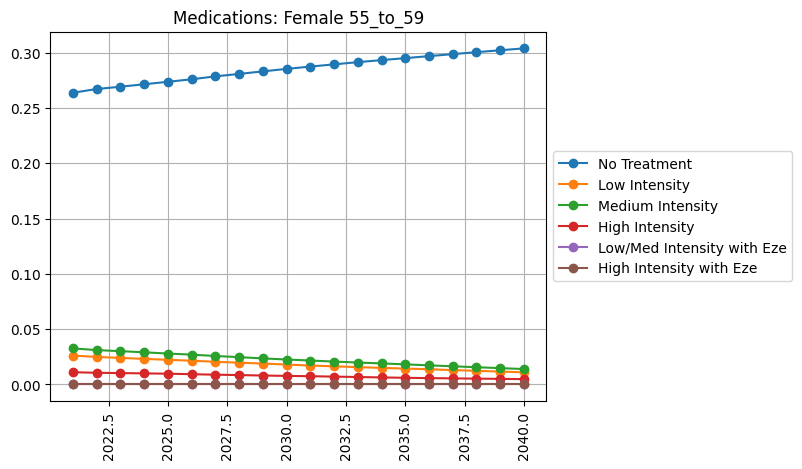

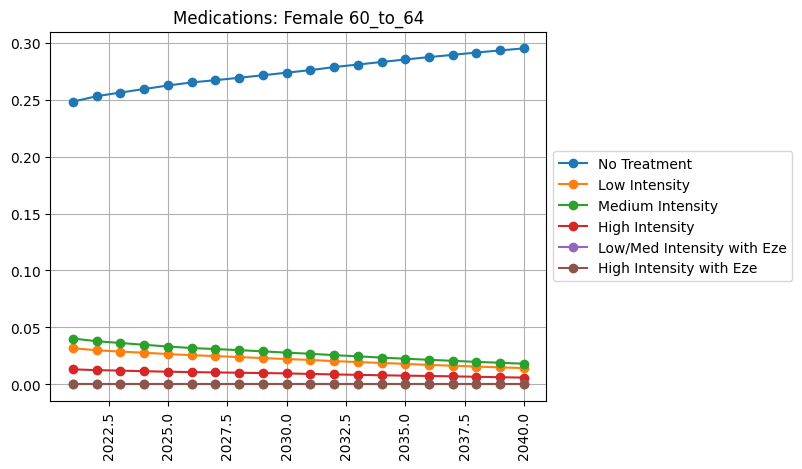

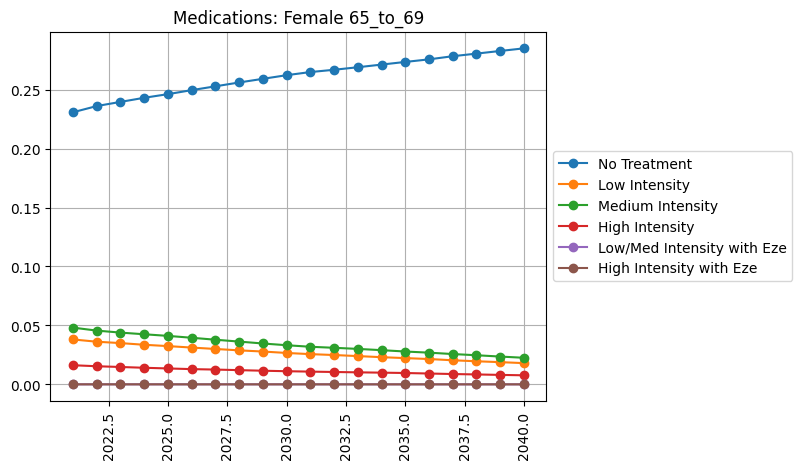

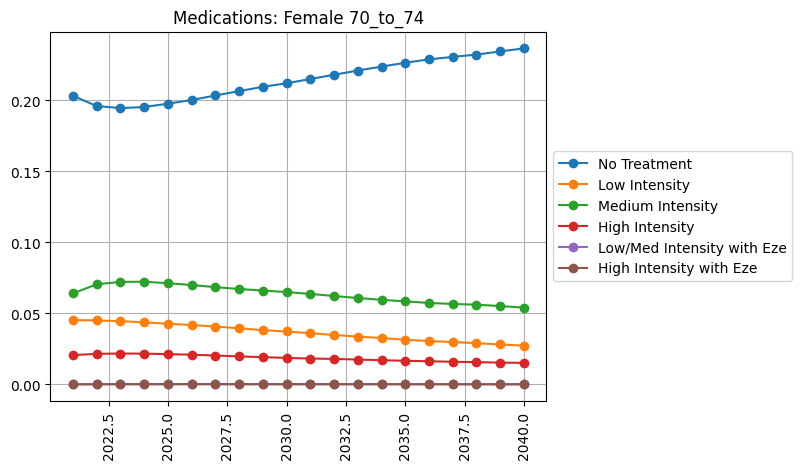

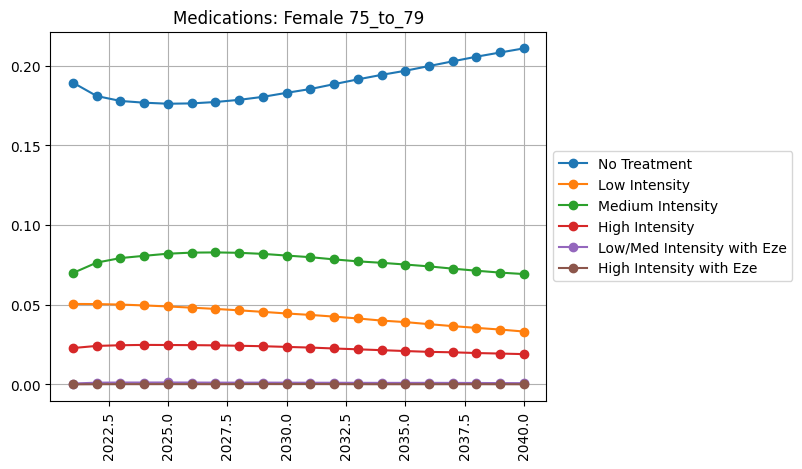

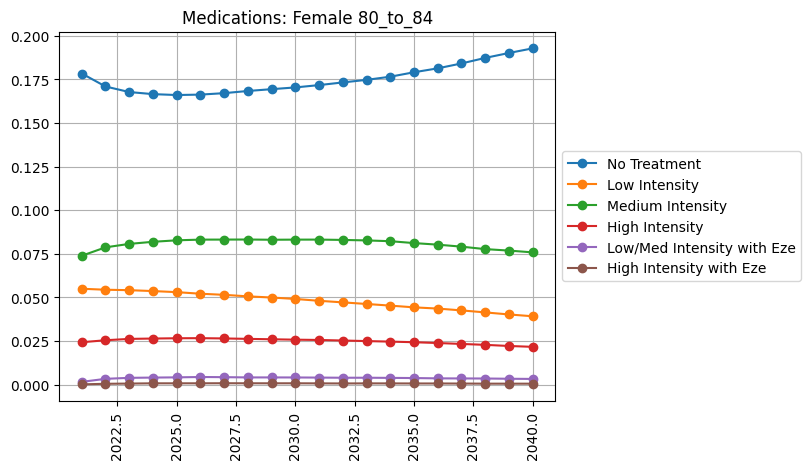

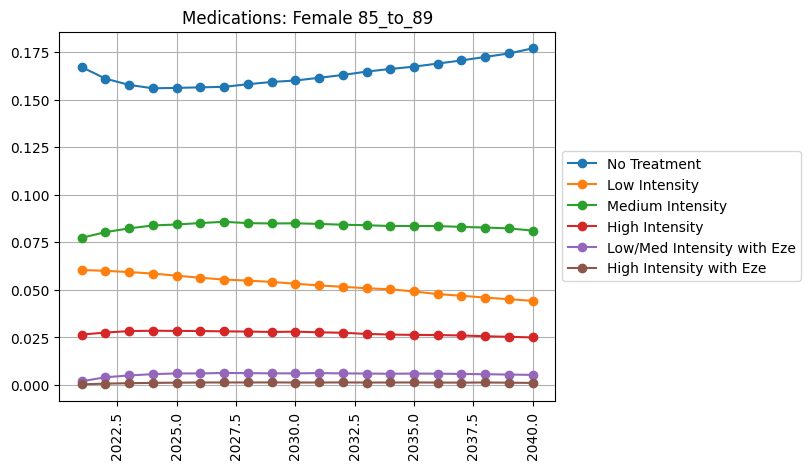

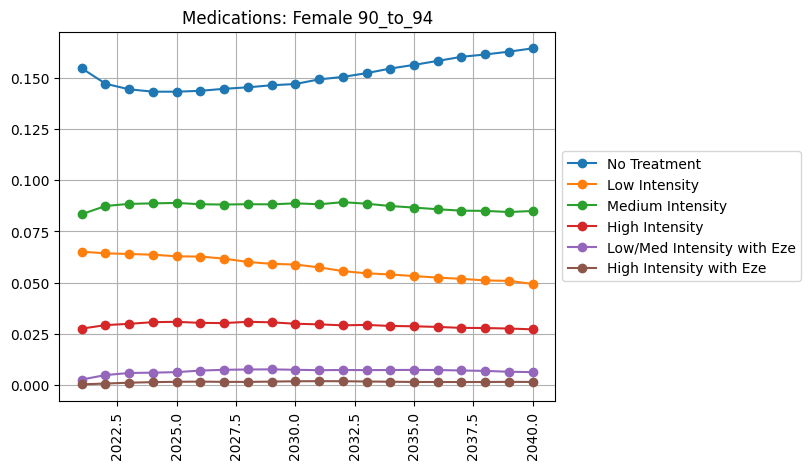

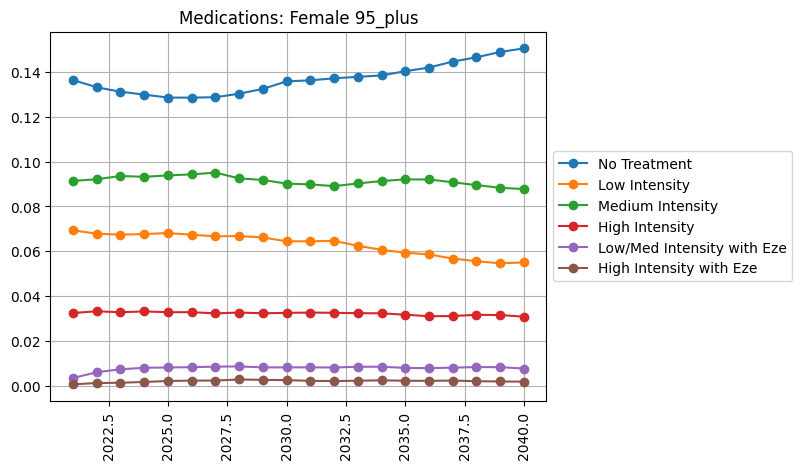

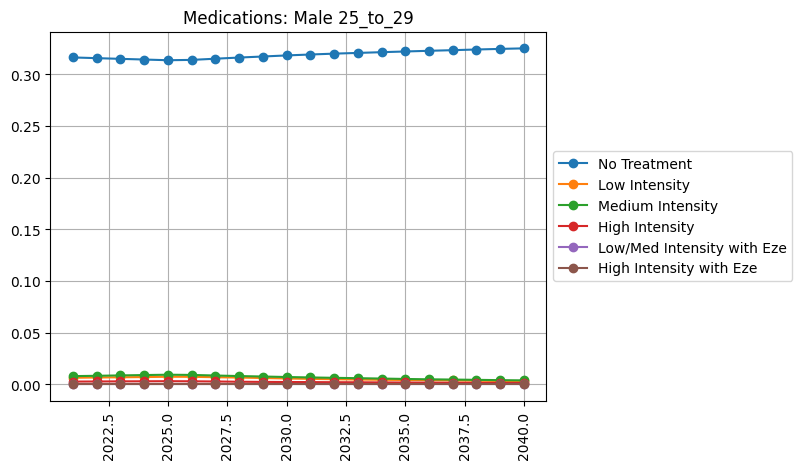

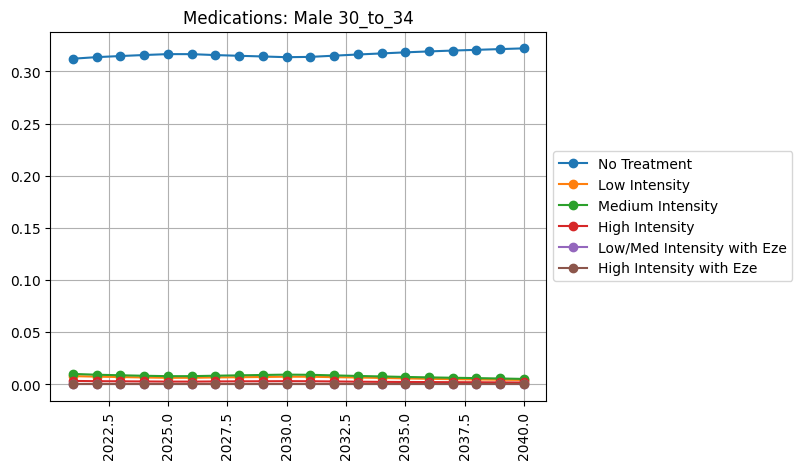

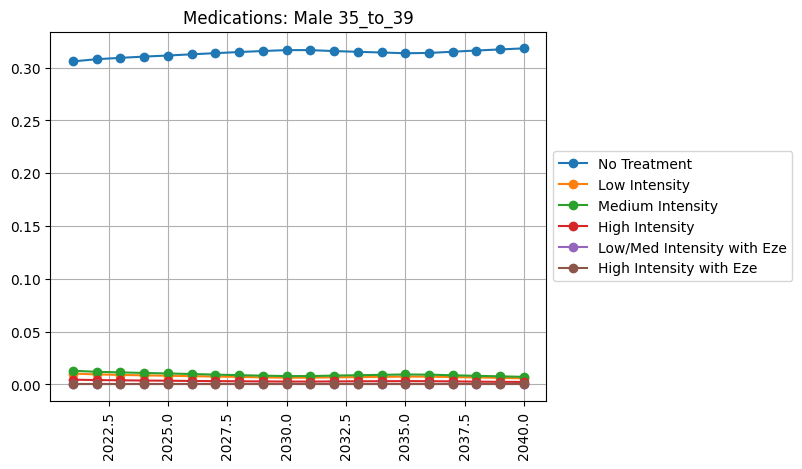

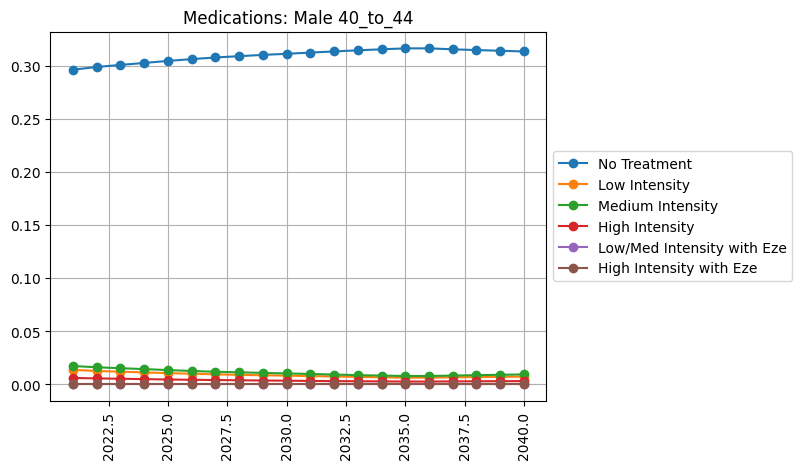

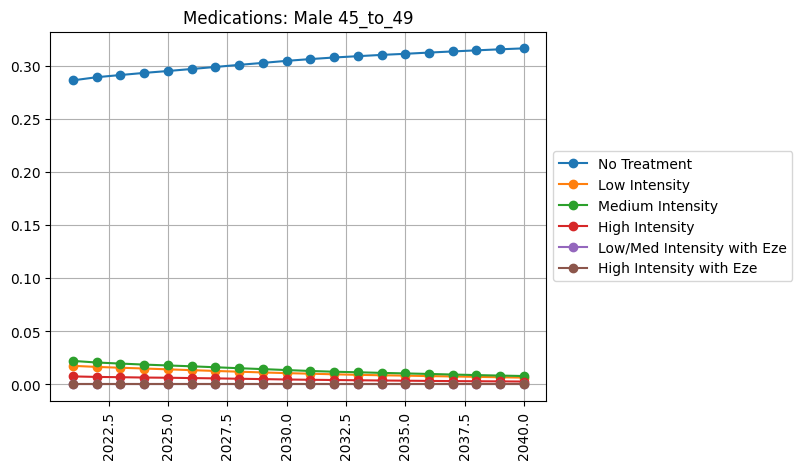

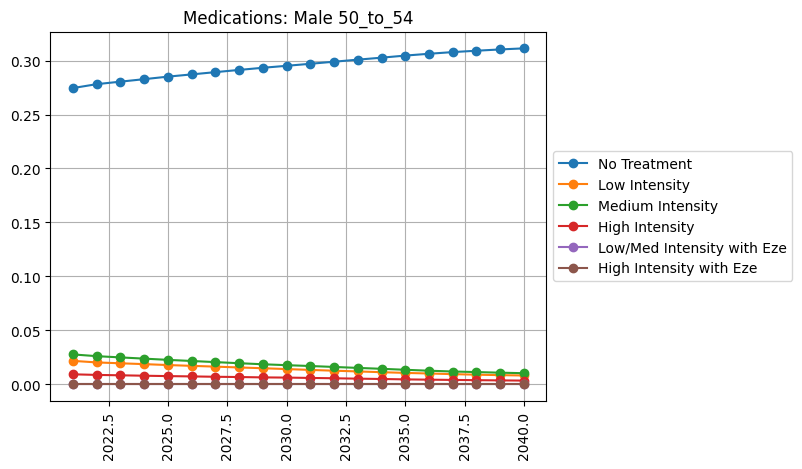

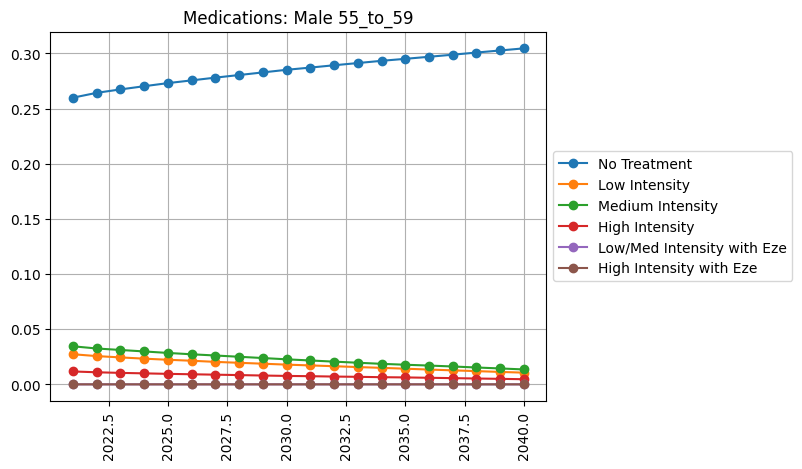

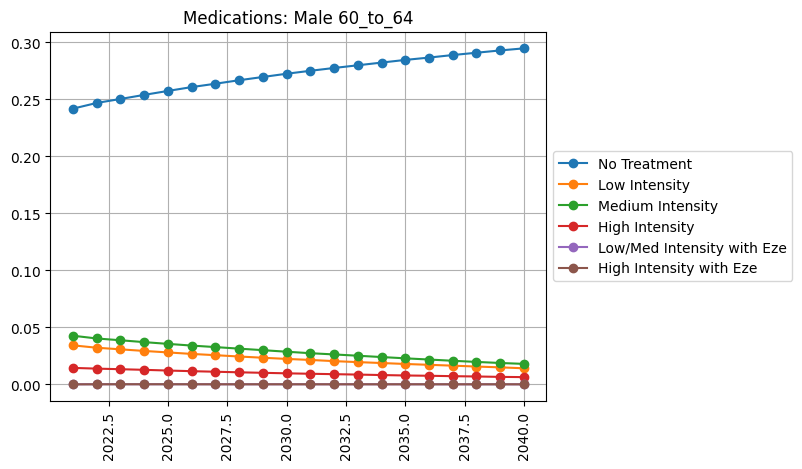

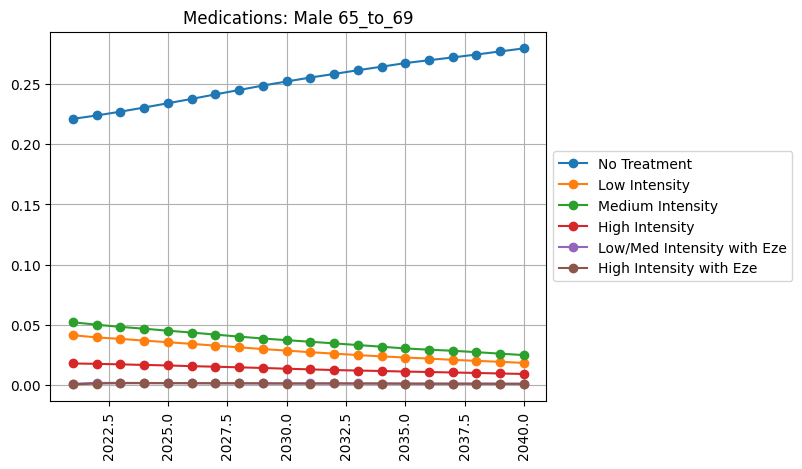

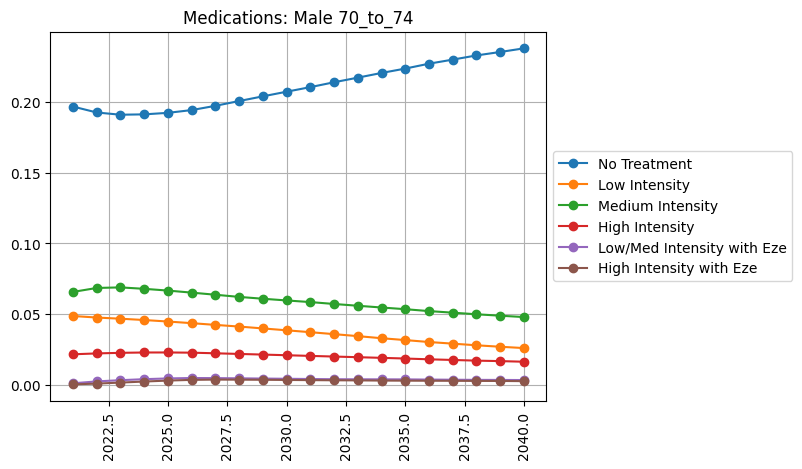

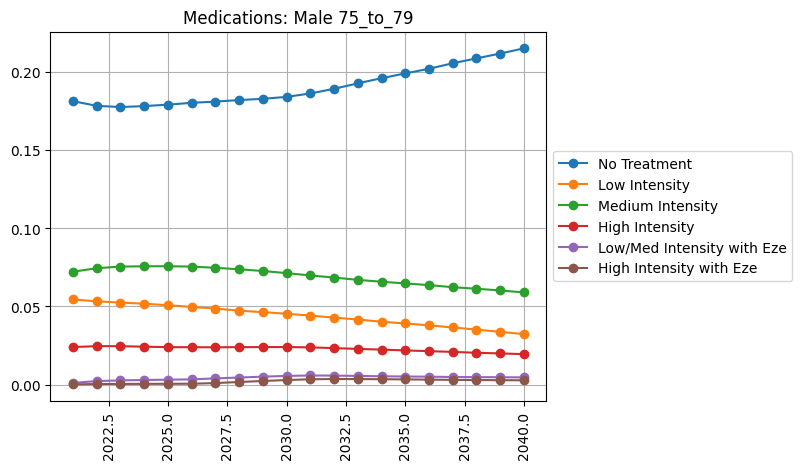

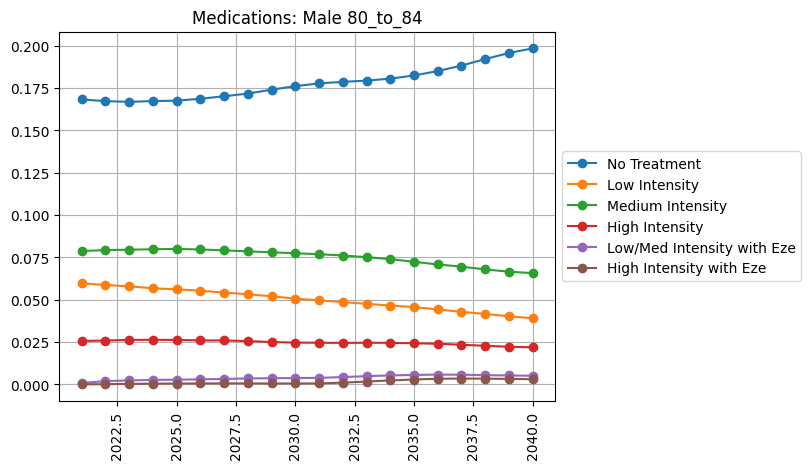

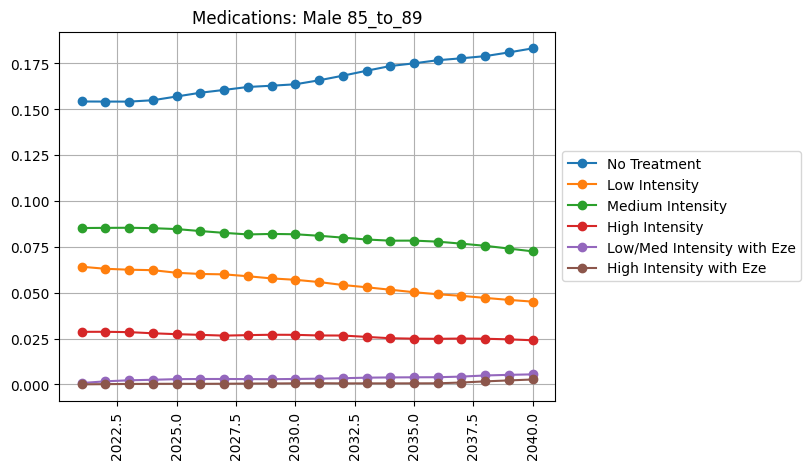

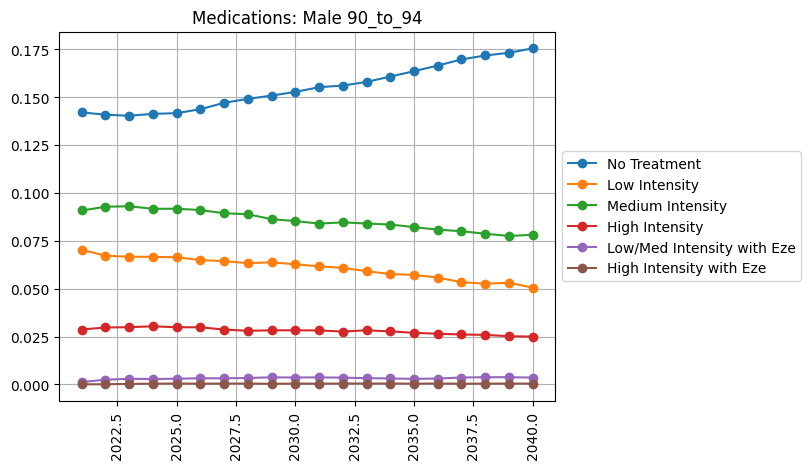

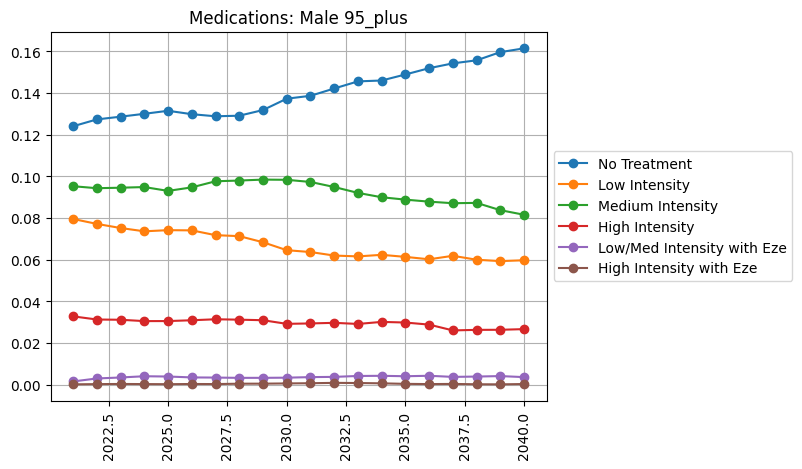

In [14]:
#%%capture
for sex in meds_adherent_rate_summ.sex.unique():
    for age in meds_adherent_rate_summ.age.unique():
        plt.figure() 
        no_trt = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='no_treatment')]
        plt.plot(no_trt['year'], no_trt['mean'], marker='o')
        one_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='low_intensity')]
        plt.plot(one_half['year'], one_half['mean'], marker='o')
        one_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='medium_intensity')]
        plt.plot(one_std['year'], one_std['mean'], marker='o')
        two_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='high_intensity')]
        plt.plot(two_half['year'], two_half['mean'], marker='o')
        two_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='low_med_with_eze')]
        plt.plot(two_std['year'], two_std['mean'], marker='o')
        three_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='high_with_eze')]
        plt.plot(three_half['year'], three_half['mean'], marker='o')
        plt.title(f'Medications: {sex} {age}') 
        plt.xticks(rotation=90)
        plt.legend(['No Treatment','Low Intensity','Medium Intensity','High Intensity','Low/Med Intensity with Eze','High Intensity with Eze'],loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid()